## Modeling Uncertainty in Random Forests and Neural Networks

This notebook produces scikit-garden and TFP predicitons for LAI and fAPAR for the NAIVE database for each biome and, using the validation datasets, compares the predicted confidence intervals to:
1. Epistemic error (Cross validation error)
2. Aleatoric error (The standard deviation of LAI and fAPAR given in the algorithm)

## Inital Setup

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [107]:
# Import modules
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [126]:
# List of biome numbers
biomes = [1,2,3,4,5,6,7,8]

In [4]:
# Read in dataset
calbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_py37/calbiomeDictLAI.pkl')
valbiomeDictLAI = pd.read_pickle('G:/cassidy/MODISLANDSAT_py37/valbiomeDictLAI.pkl')
# https://drive.google.com/drive/folders/17pL6zsZqGIPmJt5ChS_wxqVuZHdZa4Lg?usp=sharing

In [50]:
# List of regressors
regressors = ['red','NIR','cosSZA','cosVZA','cosSA']
# Response
response = 'LAI'

# Subsampling calibration and validation data to create training and testing datasets for each biome
for i in biomes:
    dfcal = calbiomeDictLAI[i]['DF'].sample(10000)
    dfval = valbiomeDictLAI[i]['DF']

    calbiomeDictLAI[i]['X_train'] = dfcal[regressors]
    calbiomeDictLAI[i]['y_train'] = dfcal[response]

    valbiomeDictLAI[i]['X_test'] = dfval[regressors]
    valbiomeDictLAI[i]['y_test'] = dfval[response]

## Random Forest

### Random Forest Regression

In [51]:
# Creating and fitting a Random Forest Regressor for each biome type (100 trees per forest)
for i in biomes:
    valbiomeDictLAI[i]['rf'] = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)
    valbiomeDictLAI[i]['rf'] = valbiomeDictLAI[i]['rf'].fit(calbiomeDictLAI[i]['X_train'], calbiomeDictLAI[i]['y_train'])

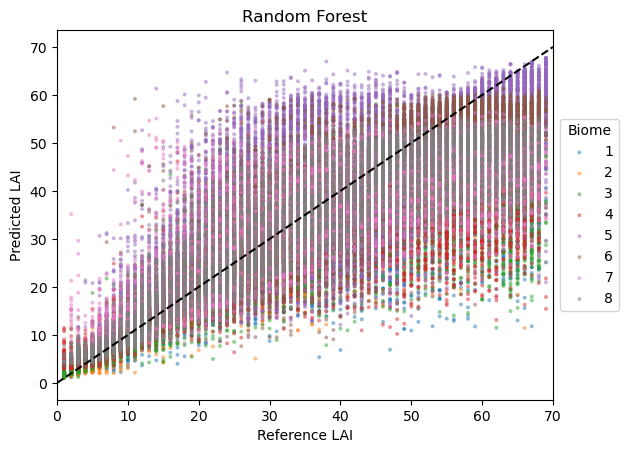

In [81]:
# Plotting the Quantile Regression Forest with error bars
axes = []
for i in biomes:
    valbiomeDictLAI[i]['DF']['y_rf'] = valbiomeDictLAI[i]['rf'].predict(valbiomeDictLAI[i]['X_test'])
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['y_rf'], s=8, alpha=0.5, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Random Forest')
plt.xlim([0, 70])
# plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

### Quantile Regression

In [8]:
%%html
<style>
table {float:left}
</style>

To use Scikit-Garden:

| Package       | Version          | Notes                    |
|:--------------|:-----------------|:-------------------------|
| python        | 3.7              |                          |
| numpy         | 1.21  (default)  |                          |
| matplotlib    | 3.5   (default)  |                          |
| pandas        | 1.2   (default)  |                          |
| scikit-learn  | 0.22  (default)  |                          |
| scikit-garden | 0.1.3 (default)  | install with conda-forge |
| jupyterlab    | 3.6   (default)  | install with pip         |

In [9]:
# Import scikit-garden module
from skgarden import RandomForestQuantileRegressor

In [10]:
# Creating a Random Forest Quantile Regressor for each biome type (100 trees per forest)
for i in biomes:
    valbiomeDictLAI[i]['rfqr'] = RandomForestQuantileRegressor(n_estimators=100,min_samples_leaf=10,max_features=5,bootstrap=True,random_state=0,verbose=0,n_jobs=-1,max_leaf_nodes=10000)

In [11]:
print(valbiomeDictLAI[1]['rfqr'])

RandomForestQuantileRegressor(bootstrap=True, criterion='mse', max_depth=None,
                              max_features=5, max_leaf_nodes=10000,
                              min_samples_leaf=10, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=100,
                              n_jobs=-1, oob_score=False, random_state=0,
                              verbose=0, warm_start=False)


In [54]:
# Fitting and predicting a Random Forest Quantile Regressor for each biome type with 95% prediction confidence interval
for i in biomes:
    valbiomeDictLAI[i]['rfqr'].set_params(max_features=calbiomeDictLAI[i]['X_train'].shape[1] // 3)
    valbiomeDictLAI[i]['rfqr'] = valbiomeDictLAI[i]['rfqr'].fit(calbiomeDictLAI[i]['X_train'], calbiomeDictLAI[i]['y_train'])
    valbiomeDictLAI[i]['DF']['upper'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=98.5)
    valbiomeDictLAI[i]['DF']['lower'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=2.5)
    valbiomeDictLAI[i]['DF']['mid'] = valbiomeDictLAI[i]['rfqr'].predict(valbiomeDictLAI[i]['X_test'], quantile=50)

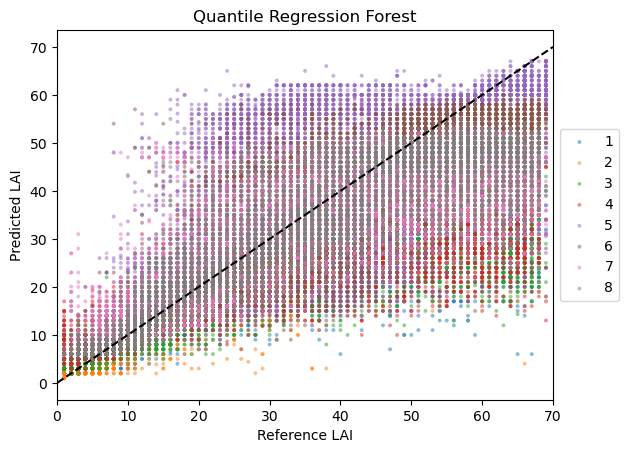

In [78]:
# Plotting the Quantile Regression Forest with error bars
axes = []
for i in biomes:
    # plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['upper'], alpha=0.5, marker='_', s=10, lw=1, edgecolors='none')
    # plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['lower'], alpha=0.5, marker='_', s=10, lw=1, edgecolors='none')
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['mid'], s=8, alpha=0.5, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Quantile Regression Forest')
plt.xlim([0, 70])
# plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Comparing Random Forest and Quantile Forest

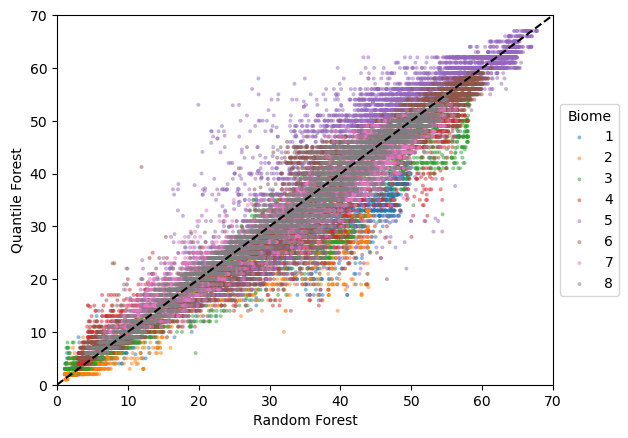

In [79]:
axes=[]
for i in biomes:
    axes.append(plt.scatter(valbiomeDictLAI[i]['DF']['y_rf'], valbiomeDictLAI[i]['DF']['mid'], s=8, alpha=0.5, edgecolors='none', label=str(i)))
    
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Random Forest")
plt.ylabel("Quantile Forest")
# plt.title('Random Forest')
plt.xlim([0, 70])
plt.ylim([0, 70])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

## Neural Network

### TensorFlow

In [97]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [98]:
np.shape(np.array(calbiomeDictLAI[i]['X_train']))

(10000, 5)

In [99]:
for i in biomes:
    normalizer = layers.Normalization(input_shape=[5,], axis=None)
    normalizer.adapt(np.array(calbiomeDictLAI[i]['X_train']))
    
    valbiomeDictLAI[i]['nn'] = tf.keras.Sequential([
        normalizer,
        layers.Dense(80, activation='relu'),
        layers.Dense(25, activation='relu'),
        layers.Dense(1)])

In [100]:
for i in biomes:
    valbiomeDictLAI[i]['nn'].compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [101]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99:                 
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [102]:
for i in biomes:
    callbacks = myCallback()
    valbiomeDictLAI[i]['nn_history'] = valbiomeDictLAI[i]['nn'].fit(calbiomeDictLAI[i]['X_train'].to_numpy(), calbiomeDictLAI[i]['y_train'].to_numpy(), epochs=50, validation_split=0.2, verbose=0, callbacks=[callbacks])
    valbiomeDictLAI[i]['DF']['y_nn'] = valbiomeDictLAI[i]['nn'].predict(valbiomeDictLAI[i]['X_test'])

211/211 [==============================] - 0s 1ms/step


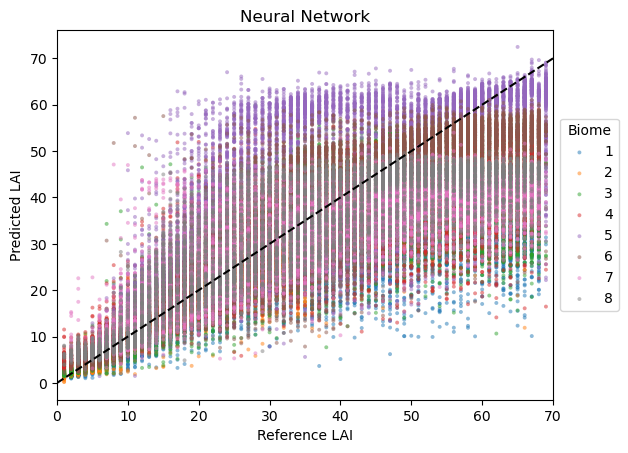

In [103]:
axes = []
for i in biomes:
    axes.append(plt.scatter(valbiomeDictLAI[i]['y_test'], valbiomeDictLAI[i]['DF']['y_nn'], s=8, alpha=0.5, edgecolors='none', label=str(i)))
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.title('Neural Network')
plt.xlim([0, 70])
# plt.ylim([-50, 120])
plt.legend(handles=axes, loc='center left', bbox_to_anchor=(1, 0.5), title='Biome')
plt.show()

In [104]:
valbiomeDictLAI[2]['nn'].summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_17 (Normaliza  (None, 5)                3         
 tion)                                                           
                                                                 
 dense_51 (Dense)            (None, 80)                480       
                                                                 
 dense_52 (Dense)            (None, 25)                2025      
                                                                 
 dense_53 (Dense)            (None, 1)                 26        
                                                                 
Total params: 2,534
Trainable params: 2,531
Non-trainable params: 3
_________________________________________________________________


In [117]:
i = 8
valbiomeDictLAI[i]['nn'].evaluate(valbiomeDictLAI[i]['X_test'],  valbiomeDictLAI[i]['y_test'], verbose=2)

211/211 - 0s - loss: 108.5382 - root_mean_squared_error: 10.4182 - 473ms/epoch - 2ms/step


[108.53824615478516, 10.418169021606445]

In [118]:
metrics.mean_squared_error(valbiomeDictLAI[i]['y_test'],valbiomeDictLAI[i]['DF']['y_rf'], squared=False)

8.930694470358052

## Questions
1. Which predictor is better in general in terms of RMSE  and bias overall and for unsaturated and saturated validation samples.
2. What is the relative size of the actual prediction residual absolute residual to the prediction confidence interval (98.5 - as a parameter)
3. What is the relative size of the standard deviation of LAI or fAPAR absolute residual to the prediction confidence interval
4. Does the prediction confidence interval change as the sample size decreases?

In [127]:
predictors = ['nn', 'rf']
for biome in biomes:
    valbiomeDictLAI[biome]['result_df'] = pd.DataFrame()
    for predictor in predictors:
        df = pd.DataFrame(data = {
            'y_true': valbiomeDictLAI[biome]['y_test'],
            'y_pred': valbiomeDictLAI[biome]['DF']['y_' + predictor],
            # 'rmse': valbiomeDictLAI[biome]['DF']['rmse_' + predictor],
            # 'residual': valbiomeDictLAI[biome]['DF']['residual_' + predictor],
            # 'sd': valbiomeDictLAI[biome]['DF']['stddev_' + predictor],
            'predictor': predictor
        })
        valbiomeDictLAI[biome]['result_df'] = pd.concat([valbiomeDictLAI[biome]['result_df'], df])

In [129]:
valbiomeDictLAI[8]['result_df']

,y_true,y_pred,predictor
0,6.0,6.762825,nn
1,49.0,39.312401,nn
2,50.0,43.037537,nn
3,7.0,6.929167,nn
4,61.0,46.552231,nn
...,...,...,...
6719,36.0,42.845235,rf
6720,20.0,20.874011,rf
6721,56.0,45.211676,rf
6722,64.0,44.863267,rf


### Question 1
Which predictor is better in general in terms of RMSE and bias overall and for unsaturated and saturated validation samples.

In [139]:
i = 6

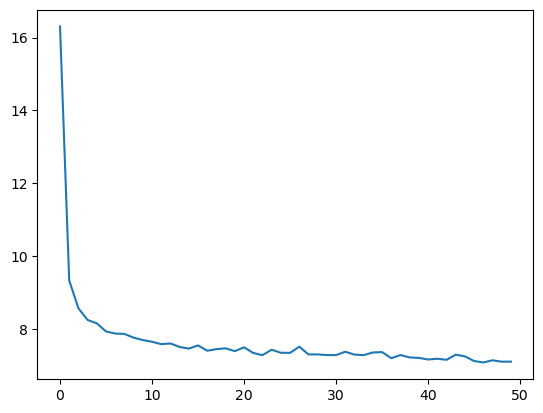

In [140]:
plt.plot(valbiomeDictLAI[i]['nn_history'].history['root_mean_squared_error'])

(-10.0, 80.0)

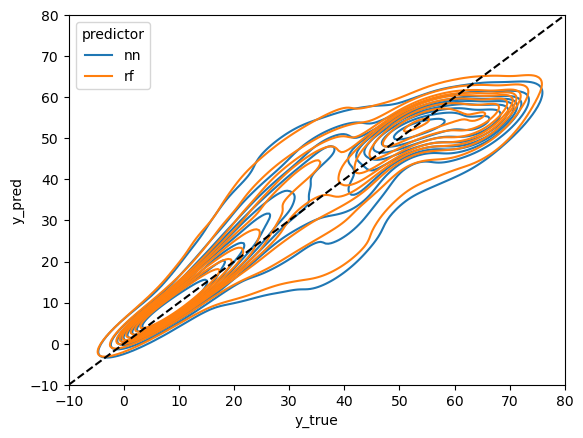

In [143]:
# kde plots of both methods on the same graph showing predicted versus actual
fig, ax = plt.subplots()
sns.kdeplot(data=valbiomeDictLAI[i]['result_df'], x='y_true', y='y_pred', hue='predictor')
plt.plot([-10, 80], [-10, 80], 'k--')
plt.xlim([-10, 80])
plt.ylim([-10, 80])

In [ ]:
# Scatter plots (with 1000 samples only) of each estimated versus predicted together with confidence intervals indicated using symbols rather than bars


### Question 2
What is the relative size of the actual prediction residual absolute residual to the prediction confidence interval (98.5 - as a parameter)

In [ ]:
# kde plots of both methods with x axis showing the prediction and y the relative size.
sns.kdeplot(data=valbiomeDictLAI[i]['result_df'], x='y_true', y='residual', hue='predictor')
plt.plot([0, 80], [0, 0], 'k--')

### Question 3
What is the relative size of the standard deviation of LAI or fAPAR  absolute residual to the  prediction confidence interval

In [ ]:
# kde plots of both methods with x axis showing the prediction and y the relative size.
sns.kdeplot(data=valbiomeDictLAI[i]['result_df'], x='y_true', y='stddev', hue='predictor')
plt.plot([-10, 80], [-10, 80], 'k--')

### Question 4
Does the prediction confidence interval change as the sample size decreases?  

In [ ]:
# For each of scikit garden and tfp network plot the confidence intervals magnitude versus the true value (maybe a kde plot) for 100% and 50% of the samples used to calibrate.